## L2 Language Learner Classification 

Building a classifier to distinguish English text written by Lang-8 users whose native language (L1) is another European language (French and Spanish) from those written by L1 speakers of East Asian languages (Japanese, Korean, and Mandarin Chinese).

### Importing Libraries

In [1]:
from zipfile import ZipFile
from bs4 import BeautifulSoup

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

nltk.download('words')
nltk.download("cmudict")

from nltk import word_tokenize
from nltk import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from nltk import pos_tag
from nltk.corpus import cmudict

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

import string

[nltk_data] Downloading package words to
[nltk_data]     /Users/snehajhaveri/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package cmudict to
[nltk_data]     /Users/snehajhaveri/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


### Text Extraction

In [26]:
def read_file_from_zip(path="data/lang-8.zip"):
    """
    A generator function which reads html documents
    as raw text from the zip file

    Parameters
    ----------
    path : string
        path to the zip file

    Returns
    -------
    A dictionary of filename and raw text extracted
    from the file
    """
    archive = ZipFile(path, "r")

    for file in archive.namelist()[1:]:
        yield {
            "filename": file,#.removeprefix("lang-8/"),
            "data": archive.read(file)
        }

In [23]:
def extract_data_from_file(path="data/lang-8.zip"):
    """
    A generator function which reads html files from zip
    and extracts text and native language from the raw
    text

    Parameters
    ----------
    path : string
        path to the zip file

    Returns
    -------
    A dictionary of extracted content and native language
    of the author
    """
    for data_dict in read_file_from_zip(path):
        soup = BeautifulSoup(data_dict["data"])

#         author = soup.find_all("p", attrs={"class": "spaced"})[1].get_text().strip()
        native_lang = soup.find("li", attrs={"data-title": "Native language"}).get_text().strip()
        filename = data_dict["filename"]
        text = soup.find("div", attrs={"id": "body_show_ori"}).get_text().strip()

        preprocessed_data = {
            "text": text,
#             "author": author,
            "native_lang": native_lang,
            "filename": filename
        }

        yield preprocessed_data

### Feature Extraction

#### Text Length

In [2]:
def get_text_length(text):
    """
    Returns the number of words in a text without punctuations. 
    Counts clitics as separate words.

    Parameters
    ----------
    text : str
        A text from which we find the number of words

    Returns
    -------
    An int which represents the number of words in the text
    """
    non_punc = []
    for word in word_tokenize(text):
        if word not in string.punctuation:
            non_punc.append(word)
    return len(non_punc)

#### Lexical Density

In [3]:
def get_lexical_density(text):
    """
    Returns the lexical density of a text. That is the ratio of open class words.
    in the text

    Parameters
    ----------
    text : str
        A text from which we find the lexical density

    Returns
    -------
    A float which represents the lexical density
    """
    open_class_prefix = {"N", "V", "J", "R"}
    open_class_total = 0
    word_count = 0
    if len(text) == 0:
        return float(0)
    for word, pos in pos_tag(word_tokenize(text)):
        if word not in string.punctuation:
            word_count += 1
            if pos[0] in open_class_prefix:
                open_class_total += 1
    return open_class_total/word_count

#### Average Sentence Length

In [4]:
def get_average_sentence_length(text):
    """
    Returns the average sentence length of a text. Does not count punctuations and counts clitics.

    Parameters
    ----------
    text : str
        A text from which we find the average sentence length

    Returns
    -------
    A float which represents the average sentence length
    """
    if len(text) == 0:
        return float(0)
    sent_lengths = 0
    for sentence in sent_tokenize(text):
        word_count = 0
        for word in word_tokenize(sentence):
            if word not in string.punctuation:
                word_count += 1
        sent_lengths += word_count
    return sent_lengths/len(sent_tokenize(text))

#### Average Word Length

In [5]:
def get_average_word_length(text):
    """
    Returns the average sentence length of a text. Does not count punctuations 
    and counts clitics.

    Parameters
    ----------
    text : str
        A text from which we find the average sentence length

    Returns
    -------
    A float which represents the average sentence length
    """
    if len(text) == 0:
        return float(0)
    word_count = 0
    lengths_sum = 0
    for word in word_tokenize(text):
        if word not in string.punctuation:
            lengths_sum += len(word)
            word_count += 1
    return lengths_sum/word_count

In [6]:
s0 = ""
s1 = """I went to the park today. 
I love going there because I always have so much fun. 
I invited some friends but they didn't come. 
That's fine because I met a new person there. 
He had a dog.
""" #40, 
s2 = "I have so much work to do today. I am stressed" #11

# get_text_length
assert type(get_text_length(s0)) == int, "Must be an interger"
assert get_text_length(s0) == 0, "Empty string must return 0"
assert get_text_length(s1) == 40, "s1 has 40 words"
assert get_text_length(s2) == 11, "s2 has 11 words"
print("get_text_length tests pass")

assert type(get_lexical_density(s0))== float, "Must be a float"
assert get_lexical_density(s0) == 0, "Empty string must return 0"
assert get_lexical_density(s1) == 24/40, "24 open class words out of 40"
assert get_lexical_density(s2) == 8/11, "8 open class words out of 40"
print("get_lexical_density tests pass")

assert type(get_average_sentence_length(s0)) == float, "Must be a float"
assert get_average_sentence_length(s0) == 0, "Empty string must return 0"
assert get_average_sentence_length(s1) == 40/5, "40 words over the span of 5 sentences"
assert get_average_sentence_length(s2) == 11/2, "11 words over the span 2 sentences"
print("get_average_sentence_length tests pass")

assert type(get_average_word_length(s0)) == float, "Must be a float"
assert get_average_word_length(s0) == 0, "Empty string must return 0"
assert get_average_word_length(s1) == 142/40, "142 total characters spread across 40 words"
assert get_average_word_length(s2) == 35/11, "35 character spread across 11 words"
print("get_average_word_length tests pass")

get_text_length tests pass
get_lexical_density tests pass
get_average_sentence_length tests pass
get_average_word_length tests pass


#### Parts of Speech Count

In [7]:
def get_pos_count(text):
    """
    Counts the number of nouns, verbs and adjectives in a text.

    Parameters
    ----------
    text : str
        A text for which we find the number of nouns, verbs
        and adjectives

    Returns
    -------
    A tuple of (noun_count: int, verb_count: int, adj_count: int)
    which represents the number of nouns, verbs adjectives in the text
    respectively
    """
    noun_count = 0
    verb_count = 0
    adj_count = 0

    if len(text) == 0:
        return 0, 0, 0

    for word, pos in pos_tag(word_tokenize(text)):
        if(pos[0] == 'N'):
            noun_count += 1
        if(pos[0] == 'V'):
            verb_count += 1
        if(pos == 'JJ'):
            adj_count += 1
    return noun_count, verb_count, adj_count

In [8]:
s1 = """I went to the park today. 
I love going there because I always have so much fun. 
I invited some friends but they didn't come. 
That's fine because I met a new person there. 
He had a dog."""

s2 = """Chelsea English School is offering a Summer School Program in Iwaki, Fukushima, a holiday learning experience combining enjoyment of the area's natural beauty and practical lifestyle immersion in the agricultural traditions of this part of Japan.
We will be hosted by "Namakiba" farm, an agricultural concern run by an Iwaki City cooperative, and activities include handson experience of organic farming,barbecues, local nature sightseeing including swimming in the river and the sea,the local fish market, guesthouses with onsens (hot spas) . The program promises new and fresh experiences in both nature and culture, and time will also be made available for gift shopping. Non-Japanese speakers are also warmly invited, as simultaneous translation into English will be available throughout the e trip."""

assert get_pos_count(s1) == (6, 10, 3)
assert get_pos_count(s2) == (47, 17, 16)

print("get_pos_count tests pass")

get_pos_count tests pass


#### Out of Vocabulary Words

In [9]:
def get_num_ovv_words(text):
    """
    Gets the number of out-of-vocabulary words in a text.

    Parameters
    ----------
    text : str
        A text for which we find the number of out-of-vocabulary
        words is to be found

    Returns
    -------
    The number of oov words in the text
    """
    text_vocab = set(w.lower() for w in text.split() if w.isalpha())
    english_vocab = set(w.lower() for w in nltk.corpus.words.words())
    ovv_words = text_vocab - english_vocab

    return len(ovv_words)

In [11]:
s0 = ""
s1 = """ I haddd to leaasve earliae since yesterday was so tired.
And then I met you.
""" 
s2 = "I have so much work to do today. I am stressseed"
assert type(get_num_ovv_words(s0)) == int, "Must be an interger"
assert get_num_ovv_words(s0) == 0, "Empty string must return 0"
assert get_num_ovv_words(s1) == 3, "s1 has 3 words out of vaocab"
assert get_num_ovv_words(s2) == 1, "s2 has 1 words out of vocab"
print("get_num_ovv_words tests pass")

get_num_ovv_words tests pass


#### Reading Ease

In [12]:
vowels = {"a","e","i","o","u","y"}
p_dict = cmudict.dict()

def get_reading_ease(text):
    """Returns the reading ease for a text.

    Parameters
    ----------
    text : str
       A text for which we find the reading ease.

    Returns
    -------
    reading_ease : float
        The reading ease for the text
    """
    syllable_count = 0
    word_count = 0

    for word in word_tokenize(text):
        if word not in string.punctuation:
            word_count += 1
            if word in p_dict:
                for pron in p_dict[word][0]:
                    if pron[-1] in ['0','1','2']:
                        syllable_count +=1
            else:
                for j in range(0,len(word)):
                    if word[j].lower() in vowels:
                         syllable_count= syllable_count+1

    reading_ease = (206.835 - (1.015*(word_count/len(sent_tokenize(text))))- (84.6*(syllable_count/word_count)))
    return reading_ease

In [13]:
assert 100 < get_reading_ease("I am done, man") < 140
assert -60 < get_reading_ease("Felicitations for achieving a thoroughly excellent resolution to an altogether indombidable conundrum of humongous proportions.") <-20
print("get_reading_ease tests pass")

get_reading_ease tests pass


#### Punctuation Counts

In [14]:
def get_punctuations_count(text):
    """
    Returns the number of punctuations in a text.

    Parameters
    ----------
    text : str
        A text for which we find the number of punctuations present

    Returns
    -------
    punct_count: int
                 An integer which represents the number of punctuations in the text
    """
    punct_count = 0
    if len(text) == 0:
        return 0
    for word in word_tokenize(text):
        if word in string.punctuation:
            punct_count += 1
    return punct_count

In [15]:
s1 = """I went to the park today. 
I love going there because I always have so much fun. 
I invited some friends but they didn't come. 
That's fine because I met a new person there. 
He had a dog."""

s2 = """Chelsea English School is offering a Summer School Program in Iwaki, Fukushima, a holiday learning experience combining enjoyment of the area's natural beauty and practical lifestyle immersion in the agricultural traditions of this part of Japan.
We will be hosted by "Namakiba" farm, an agricultural concern run by an Iwaki City cooperative, and activities include handson experience of organic farming,barbecues, local nature sightseeing including swimming in the river and the sea,the local fish market, guesthouses with onsens (hot spas) . The program promises new and fresh experiences in both nature and culture, and time will also be made available for gift shopping. Non-Japanese speakers are also warmly invited, as simultaneous translation into English will be available throughout the e trip."""


assert get_punctuations_count(s1) == 5
assert get_punctuations_count(s2) == 16

print("get_punctuations_count tests pass")

get_punctuations_count tests pass


#### Type-Token Ratio

In [16]:
def get_type_token_ratio(text):
    """
    Calculate type-token ratio from the text using the first
    num_words tokens

    Parameters
    ----------
    text : str
        A text for which we find the type-token ratio

    Returns
    -------
    type_token_ratio: int
                    An integer which represents the type token ratio for a given text
    """
    words = text.split()
    num_words = 100
    type_set = set(word.lower() for word in words[:num_words])
    return len(type_set) / num_words

In [17]:
s1 = """Chelsea English School is offering a Summer School Program in Iwaki, Fukushima, a holiday learning experience combining enjoyment of the area's natural beauty and practical lifestyle immersion in the agricultural traditions of this part of Japan.
We will be hosted by "Namakiba" farm, an agricultural concern run by an Iwaki City cooperative, and activities include handson experience of organic farming,barbecues, local nature sightseeing including swimming in the river and the sea,the local fish market, guesthouses with onsens (hot spas) . The program promises new and fresh experiences in both nature and culture, and time will also be made available for gift shopping. Non-Japanese speakers are also warmly invited, as simultaneous translation into English will be available throughout the e trip."""

s2 = """I'd like to acquire this skill, however it doesn't really fit into my schedule right now. I'm still practicing a little bit every day.Well, I'll attend my exam within 8 weeks and a few days, but I've still many things to learn. That's what we call a challenge, so I find it quite interesting."""
assert get_type_token_ratio(s1) == 0.74
assert get_type_token_ratio(s2) == 0.48

print("get_type_token_ratio tests pass")

get_type_token_ratio tests pass


#### Asian Context

In [18]:
def get_asian_context_feature(text):
    """
    Return a binary value based on whether asian journal's context based words are present in the text

    Parameters
    ----------
    text : str
        A text for which we find the presence of the words

    Returns
    -------
    value : boolean
            0 represents that the no word in the list is present in the text and 1 represents vice versa.
    """

    lemmatizer = WordNetLemmatizer()
    with open("data/asian_words.txt", "r") as file:
        asian_journals_context_words = file.read().split("\n")

    for word in word_tokenize(text):
        if lemmatizer.lemmatize(word) in asian_journals_context_words:
            return 1
    return 0

In [19]:
asian_journal_test = """Frank moved to Guangzhou after long time consideration from another city. Finally he settled down in his new apartment and we had a welcome dinner together last night in a Indonesian restaurant which was absolutely new for me. 
I have not tried Indonesian food before but similar ones such as Singaporean and Malaysian dishes when I traveled there back to 2007. Southeast Asia food is full of spicy, curry tasting in common. I like it since the influence I got from my previous company, a Singapore based firm in Shanghai. I had good memory both about my pre-boss and good trip in Singapore and Malaysia. I was treated with lots of fun, adventure, foods and for sure can not be forgotten, humid and hot weather. 
Ok, back to the Indonesian restaurant. It is a tradtional one decorating with local stuff, french window, cane chair with the gentle local background music. I can smell the Indonesian in air. The dishes were really good and mostly important the price is fair too."""

asian_journal_test_2 = """Today I had TV conference with Malaysian in English.I know we Japanese have strong accent ourselves, but I think for me their English is very difficult to understand as well. I would like to get used to their accent."""

european_journal_test = """I am missing the friends, and I will miss my life in US. It hasn't been easy for me to stay here, mainly because of my English limitation, but now I wish I could stay longer here. Because I like California."""

european_journal_test_2 = """A few days ago, I've discovered something pretty awesome: it is called penmanship.
It could be decribed as the art of writing. After much practice, the results are really great."""

assert get_asian_context_feature(asian_journal_test) == 1
assert get_asian_context_feature(european_journal_test) == 0
assert get_asian_context_feature(asian_journal_test_2) == 1
assert get_asian_context_feature(european_journal_test_2) == 0

print("get_asian_context_feature tests pass")

get_asian_context_feature tests pass


#### Word Importance

In [20]:
def get_word_importance(text):
    """This is a helper function to generate TF IDF scores for words present in the input text"""
    count = CountVectorizer(stop_words='english', analyzer='word')
    word_count = count.fit_transform(text)

    tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
    tfidf_transformer.fit(word_count)
    tf_idf_vector = tfidf_transformer.transform(word_count)

    feature_names = count.get_feature_names_out()
    first_document_vector = tf_idf_vector[0]

    df_tfifd = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
    df_tfifd = df_tfifd.sort_values(by=["tfidf"], ascending=False)

    return df_tfifd

In [24]:
def get_top_important_words():
    """This is a helper function to fetch words with top TF IDF scores for both asian and european journals"""

    no_of_top_words = 30

    asian_lang_text = []
    non_asian_lang_text = []

    lemmatizer = WordNetLemmatizer()
    asian_lang = ["Korean", "Japanese", "Mandarin Chinese"]

    for extracted_data in extract_data_from_file():
        if extracted_data['native_lang'] in asian_lang:
            asian_lang_text.append(extracted_data['text'] + ", ")
        else:
            non_asian_lang_text.append(extracted_data['text'] + ", ")

    asian_imp_words_df = get_word_importance(asian_lang_text)
    non_asian_imp_words_df = get_word_importance(non_asian_lang_text)

    asian_imp_words = asian_imp_words_df.index[:no_of_top_words]
    asian_imp_words_lem = [lemmatizer.lemmatize(x) for x in asian_imp_words]

    non_asian_imp_words = non_asian_imp_words_df.index[:no_of_top_words]
    non_asian_imp_words_lem = [lemmatizer.lemmatize(x) for x in non_asian_imp_words]

    return asian_imp_words_lem, non_asian_imp_words_lem

In [27]:
asian_imp_words_index, non_asian_imp_words_index = get_top_important_words()

#### Asian Important Words

In [28]:
def get_imp_words_asian_feature(text):
    """
    Return a binary value based on whether asian journal's important words (based on TF-IDF scores) are present in the text

    Parameters
    ----------
    text : str
        A text for which we find the presence of the words

    Returns
    -------
    value : boolean
            0 represents that the no word in the list is present in the text and 1 represents vice versa.
    """
    lemmatizer = WordNetLemmatizer()

    for word in word_tokenize(text):
        if lemmatizer.lemmatize(word) in asian_imp_words_index:
            return 1

    return 0

#### Non-Asian Important Words

In [29]:
def get_imp_words_non_asian_feature(text):
    """
    Return a binary value based on whether european journal's important words (based on TF-IDF scores) are present in the text

    Parameters
    ----------
    text : str
        A text for which we find the presence of the words

    Returns
    -------
    value : boolean
            0 represents that the no word in the list is present in the text and 1 represents vice versa.
    """
    lemmatizer = WordNetLemmatizer()

    for word in word_tokenize(text):
        if lemmatizer.lemmatize(word) in non_asian_imp_words_index:
            return 1
    return 0

In [30]:
test_text_asian_feature = """Hi, my name is Sebastián. This is the first time I write here at Lang-8, and to be honest it’s hard for me to decide what to talk about, but if you don’t make up your mind and practice you’ll never improve, so here I go…
I’m studying English and Japanese. I use the computer and internet a lot for studying, which has given me access to several and great tools that every language learner should have access to, like blogs, forums, podcasts, sowftware and others..
As for English, its pronunciation is hard, but reading isn’t that much hard. Besides, on internet there are amazing amounts of information in English about any subject. For example, I like stuff related to the use of computers and internet for both leisure and learning, and read sites like Lifehacker and Wikipedia and several others everyday. Actually, I’ve learned a lot of English by reading and writing at sites about learning Japanese.
On the other side, reading Japanese is something that takes lots of time and effort. Even something as “simple” as reading the newspaper isn’t that “simple” at all. Fortunately, I study kanji using a book called “Remembering the Kanji” by James Heisig, and also spaced repetition softwares for kanji and Japanese in general, which has helped me a lot not just to actually learn, but also to feel much more motivated to keep on learning.
As I said above, the use of the computer and internet has helped me a lot. I think this is the best moment to learn languages, as practically anything you need can be found on internet, and even for free. For example, Lang-8 is a great tool for every language learner, so I hope it keeps on having great success.
What do you think?"""

test_text_non_asian_feature = """A few days ago, I've discovered something pretty awesome: it is called penmanship.
It could be decribed as the art of writing. After much practice, the results are really great."""


assert get_imp_words_asian_feature(test_text_asian_feature) == 1
assert get_imp_words_non_asian_feature(test_text_asian_feature) == 0
assert get_imp_words_non_asian_feature(test_text_non_asian_feature) == 1
assert get_imp_words_asian_feature(test_text_non_asian_feature) == 0

print("get_imp_words_asian_feature tests pass")
print("get_imp_words_non_asian_feature tests pass")

get_imp_words_asian_feature tests pass
get_imp_words_non_asian_feature tests pass


In [28]:
def get_document_list(txt_path):
    """
    Extracts the list of documents stores in a text file

    Parameters
    ----------
    text_path : str
        The string defining path of the text document

    Returns
    -------
    A list of filenames extracted from the file
    """
    doc_list = []

    with open(txt_path, "r") as f:
        for filename in f.readlines():
            doc_list.append(filename.strip())

    return doc_list

In [31]:
def extract_all_features(
    txt_path, csv_path, zip_path="data/lang-8.zip", verbose=False
):
    """
    Reads the zip file from path, extracts features from
    preprocessed text and combines them together to save
    them to a csv file

    Parameters
    ----------
    csv_path : str
            path at which the generated csv file is to be saved
    zip_path : str
            path to the zip file
    verbose : boolean
            specify whether to print the processed filename or not
    """

    # Return if the file already exists
    if os.path.isfile(csv_path):
        return

    # Lists of relevant features
    asian_lang = ["Korean", "Japanese", "Mandarin Chinese"]
    names = []
    text_lens = []
    lexical_densities = []
    avg_sent_lens = []
    avg_word_lens = []
    oov_word_counts = []

    reading_eases = []
    punctuations_counts = []
    type_token_ratios = []
    asian_context_features = []
    imp_words_asian_features = []
    imp_words_non_asian_features = []

    noun_counts, verb_counts, adj_counts = [], [], []
    targets = []

    # Lists of training, validation and test files
    doc_list = get_document_list(txt_path)

    for extracted_data in extract_data_from_file(zip_path):

        if extracted_data["filename"].removeprefix("lang-8/") not in doc_list:
            continue

        if extracted_data["native_lang"] == "Russian":
            continue

        if extracted_data['native_lang'] in asian_lang:
            target = 1
        else:
            target = 0

        targets.append(target)
        names.append(extracted_data['filename'][7:-5])
        text_lens.append(get_text_length(extracted_data['text']))
        lexical_densities.append(get_lexical_density(extracted_data['text']))
        avg_sent_lens.append(get_average_sentence_length(extracted_data['text']))
        avg_word_lens.append(get_average_word_length(extracted_data['text']))
        oov_word_counts.append(get_num_ovv_words(extracted_data['text']))

        reading_eases.append(get_reading_ease(extracted_data['text']))
        punctuations_counts.append(get_punctuations_count(extracted_data['text']))
        type_token_ratios.append(get_type_token_ratio(extracted_data['text']))
        asian_context_features.append(get_asian_context_feature(extracted_data['text']))
        imp_words_asian_features.append(get_imp_words_asian_feature(extracted_data['text']))
        imp_words_non_asian_features.append(get_imp_words_non_asian_feature(extracted_data['text']))

        noun_count, verb_count, adj_count = get_pos_count(extracted_data['text'])
        noun_counts.append(noun_count)
        verb_counts.append(verb_count)
        adj_counts.append(adj_count)

        if verbose:
            print(len(targets), extracted_data["filename"])

    feature_df = pd.DataFrame(
        np.array([
            names,
            text_lens,
            lexical_densities,
            avg_sent_lens,
            avg_word_lens,
            oov_word_counts,

            reading_eases,
            punctuations_counts,
            type_token_ratios,
            asian_context_features,
            imp_words_asian_features,
            imp_words_non_asian_features,

            noun_counts,
            verb_counts,
            adj_counts,
            targets
        ]).T,
        columns=[
            "filename",
            "text_length",
            "lexical_density",
            "average_sentence_length",
            "average_word_length",
            "oov_word_counts",

            "reading_ease",
            "punctuation_count",
            "type_token_ratio",
            "asian_context_feature",
            "asian_imp_word",
            "non_asian_imp_word",

            "noun_counts",
            "verb_counts",
            "adjective_counts",
            "target_region"
        ])

    feature_df.to_csv(csv_path)

In [32]:
def create_train_dev_test_csvs(paths={
                                    "data/train.txt": "data/train.csv",
                                    "data/dev.txt": "data/dev.csv",
                                    "data/test.txt": "data/test.csv"
                                },
                               zip_path="data/lang-8.zip"):
    """
    Takes in paths of text documents containing filenames from which
    information is to be extracted, extracts informtion from them and
    store them as csvs for train, validation and test

    Parameters
    ----------
    paths : dict
        a dictionary with keys as paths for text documents to read filenames
        and values as paths for the csv documents to save extracted features
    zip_path : str
            path to the zip file
    """

    for txt_path, csv_path in paths.items():
        extract_all_features(txt_path, csv_path, zip_path)

In [33]:
def read_csvs(train, val, test):
    """
    Reads train, validation and test sets from disk

    Parameters
    ----------
    train : str
        The path of the training csv file
    train : str
        The path of the training csv file
    train : str
        The path of the training csv file

    Returns
    -------
    A tuple of train, validation and test dataframes
    """
    train_csv = None
    val_csv = None
    test_csv = None

    try:
        train_csv = pd.read_csv(train)
    except:
        pass
    try:
        val_csv = pd.read_csv(val)
    except:
        pass
    try:
        test_csv = pd.read_csv(test)
    except:
        pass

    return train_csv, val_csv, test_csv

In [34]:
# Reading the data

train_csv_path = r"data/train.csv"
val_csv_path = r"data/dev.csv"
test_csv_path = r"data/test.csv"

train_txt_path = r"data/train.txt"
val_txt_path = r"data/dev.txt"
test_txt_path = r"data/test.txt"

paths = {
    train_txt_path: train_csv_path,
    val_txt_path: val_csv_path,
    test_txt_path: test_csv_path
}

zip_path = r"data/lang-8.zip"

if not (os.path.isfile(
    train_csv_path
) and os.path.isfile(
    val_csv_path
) and os.path.isfile(
    test_csv_path
)):
    create_train_dev_test_csvs(paths)

train_data, val_data, test_data = read_csvs(train_csv_path, val_csv_path, test_csv_path)

### Exploratory Data Analysis (EDA)

In [35]:
train_data = train_data.drop(columns=["Unnamed: 0", "filename"])
train_data

,text_length,lexical_density,average_sentence_length,average_word_length,oov_word_counts,reading_ease,punctuation_count,type_token_ratio,asian_context_feature,asian_imp_word,non_asian_imp_word,noun_counts,verb_counts,adjective_counts,target_region
0,281,0.480427,70.250000,4.259786,21,18.717015,18,0.61,0,0,1,79,41,11,0
1,29,0.655172,29.000000,4.448276,1,46.124138,1,0.22,0,0,0,5,7,5,0
2,307,0.592834,38.375000,4.566775,17,37.815320,20,0.77,0,1,0,95,52,14,1
3,67,0.611940,22.333333,4.104478,5,57.898010,13,0.50,0,1,0,18,15,6,1
4,25,0.520000,25.000000,3.520000,0,79.940000,2,0.18,0,0,1,4,7,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,107,0.532710,53.500000,4.130841,6,29.981098,5,0.74,1,0,0,19,26,4,1
739,64,0.671875,32.000000,4.296875,0,48.776875,13,0.49,1,0,0,20,13,7,1
740,63,0.523810,21.000000,3.952381,3,70.034286,6,0.49,0,0,1,13,14,1,1
741,37,0.702703,37.000000,4.567568,2,29.804324,2,0.30,0,0,1,10,12,3,1


In [36]:
val_data = val_data.drop(columns=["Unnamed: 0", "filename"])
val_data

,text_length,lexical_density,average_sentence_length,average_word_length,oov_word_counts,reading_ease,punctuation_count,type_token_ratio,asian_context_feature,asian_imp_word,non_asian_imp_word,noun_counts,verb_counts,adjective_counts,target_region
0,699,0.595136,14.265306,4.214592,40,69.147131,87,0.70,0,1,1,158,157,51,1
1,618,0.600324,22.888889,4.872168,34,44.108603,61,0.70,0,1,1,173,88,53,0
2,83,0.590361,20.750000,4.421687,5,53.267726,13,0.67,1,1,0,20,17,9,1
3,32,0.625000,32.000000,4.406250,1,50.098750,3,0.27,1,0,0,7,9,2,0
4,70,0.585714,23.333333,4.828571,4,50.208810,14,0.51,1,1,0,25,13,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,73,0.602740,12.166667,3.849315,1,80.913231,7,0.53,0,0,1,12,16,8,1
242,88,0.579545,12.571429,3.829545,2,82.556818,13,0.63,0,1,0,19,19,10,1
243,37,0.648649,18.500000,4.810811,0,41.722365,9,0.33,0,0,0,13,8,3,1
244,322,0.562112,21.466667,4.760870,14,57.095402,59,0.81,0,1,1,79,53,39,1


In [37]:
test_data = test_data.drop(columns=["Unnamed: 0", "filename"])
test_data

,text_length,lexical_density,average_sentence_length,average_word_length,oov_word_counts,reading_ease,punctuation_count,type_token_ratio,asian_context_feature,asian_imp_word,non_asian_imp_word,noun_counts,verb_counts,adjective_counts,target_region
0,47,0.638298,11.750000,3.957447,0,79.708750,5,0.38,0,0,0,14,9,5,1
1,73,0.671233,73.000000,4.575342,4,-8.646301,8,0.53,1,0,0,22,15,9,1
2,52,0.634615,17.333333,3.692308,1,67.222436,11,0.33,0,0,0,8,12,9,0
3,80,0.650000,80.000000,4.337500,7,9.310000,1,0.52,0,0,0,21,20,3,1
4,187,0.572193,31.166667,4.181818,7,62.099229,25,0.73,0,0,1,42,31,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,47,0.787234,47.000000,5.425532,2,0.730000,0,0.39,1,0,0,22,8,5,1
248,39,0.615385,39.000000,4.282051,1,39.265385,4,0.32,0,0,0,8,12,3,1
249,19,0.842105,19.000000,5.789474,2,4.992105,2,0.18,0,0,0,9,3,2,1
250,110,0.600000,22.000000,4.709091,6,55.297727,8,0.79,0,1,1,30,20,7,0


In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   text_length              743 non-null    int64  
 1   lexical_density          743 non-null    float64
 2   average_sentence_length  743 non-null    float64
 3   average_word_length      743 non-null    float64
 4   oov_word_counts          743 non-null    int64  
 5   reading_ease             743 non-null    float64
 6   punctuation_count        743 non-null    int64  
 7   type_token_ratio         743 non-null    float64
 8   asian_context_feature    743 non-null    int64  
 9   asian_imp_word           743 non-null    int64  
 10  non_asian_imp_word       743 non-null    int64  
 11  noun_counts              743 non-null    int64  
 12  verb_counts              743 non-null    int64  
 13  adjective_counts         743 non-null    int64  
 14  target_region            7

In [39]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
text_length,743.0,108.492598,117.516712,1.000000,41.500000,74.000000,133.000000,1185.00
lexical_density,743.0,0.614475,0.092623,0.333333,0.558528,0.600000,0.646110,1.00
average_sentence_length,743.0,30.431251,32.568711,1.000000,13.000000,21.000000,35.000000,403.00
average_word_length,743.0,4.433092,2.683678,2.428571,3.916667,4.191489,4.541325,66.00
oov_word_counts,743.0,6.328398,9.106281,0.000000,2.000000,4.000000,7.000000,111.00
reading_ease,743.0,53.392032,42.705474,-330.054665,40.071008,60.056250,74.395216,205.82
punctuation_count,743.0,12.671602,14.992625,0.000000,4.000000,8.000000,16.000000,139.00
type_token_ratio,743.0,0.499892,0.223763,0.010000,0.320000,0.530000,0.700000,0.88
asian_context_feature,743.0,0.169583,0.375519,0.000000,0.000000,0.000000,0.000000,1.00
asian_imp_word,743.0,0.492598,0.500282,0.000000,0.000000,0.000000,1.000000,1.00


__Data Imbalance__

In [40]:
test_data["target_region"].value_counts(normalize=True)

0    0.662698
1    0.337302
Name: target_region, dtype: float64

In [41]:
train_data.columns

Index(['text_length', 'lexical_density', 'average_sentence_length',
       'average_word_length', 'oov_word_counts', 'reading_ease',
       'punctuation_count', 'type_token_ratio', 'asian_context_feature',
       'asian_imp_word', 'non_asian_imp_word', 'noun_counts', 'verb_counts',
       'adjective_counts', 'target_region'],
      dtype='object')

In [42]:
# Selecting feature types

binary_features_org = [
    "asian_context_feature",
    "asian_imp_word",
    "non_asian_imp_word"
]

target = "target_region"

numeric_features_org = list(
    set(train_data.columns)
    - set(binary_features_org)
    - set([target])
)

assert train_data.columns.shape[0] == len(
    binary_features_org
    + numeric_features_org
    + [target]
)

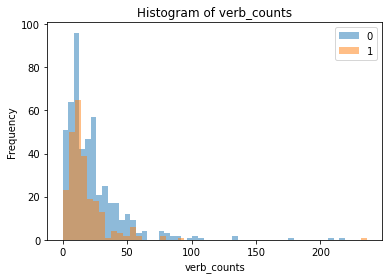

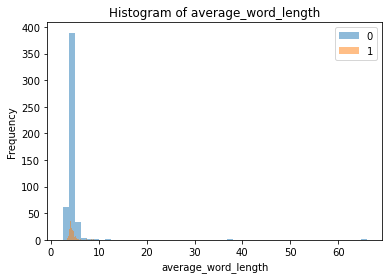

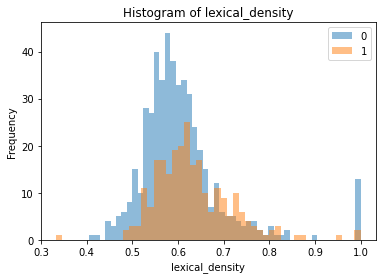

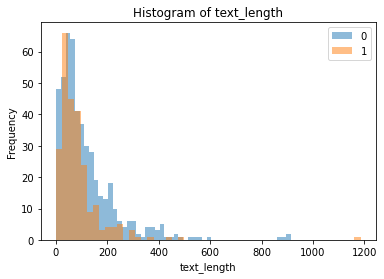

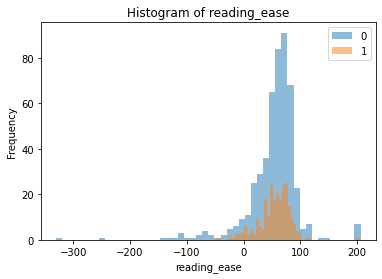

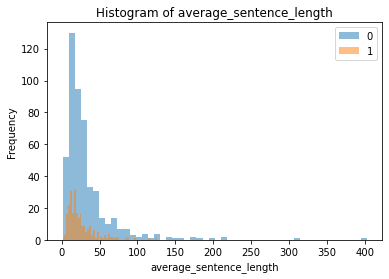

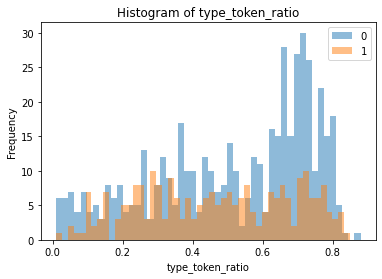

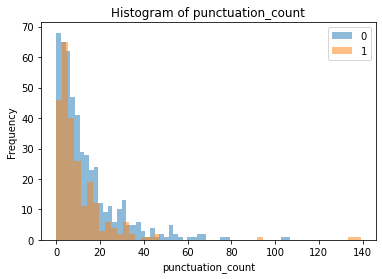

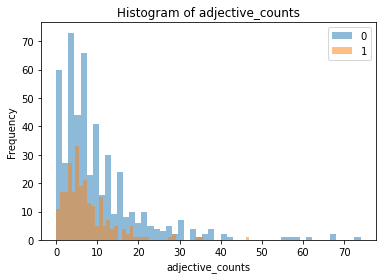

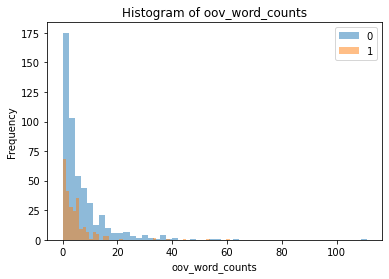

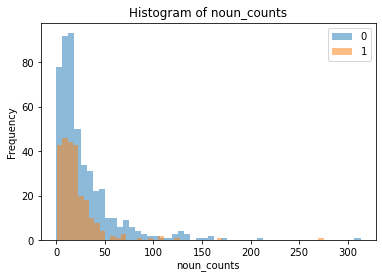

In [43]:
for i in numeric_features_org:
    feat = i
    ax = train_data.groupby("target_region")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

__Interpretation__

From the above histograms, we observe that several features have some differences between the two groups. Visually, we observe a difference in average sentence length where the European L1 speakers are writing longer sentences. We also observe that there is a greater variance for the lexical density between the 2 groups for example for lexical density between around 0.45 to 0.47 there is a clear distinction that the speaker is European.

In [44]:
cor = train_data[numeric_features_org].corr()
cor

,verb_counts,average_word_length,lexical_density,text_length,reading_ease,average_sentence_length,type_token_ratio,punctuation_count,adjective_counts,oov_word_counts,noun_counts
verb_counts,1.000000,-0.056303,-0.256744,0.962714,-0.187747,0.217404,0.585557,0.818669,0.841040,0.651704,0.822225
average_word_length,-0.056303,1.000000,0.330453,-0.046317,0.130178,-0.023097,-0.126859,-0.049673,-0.035431,-0.014697,-0.021260
lexical_density,-0.256744,0.330453,1.000000,-0.261107,0.057953,-0.094276,-0.399201,-0.228157,-0.159322,-0.075238,-0.154874
text_length,0.962714,-0.046317,-0.261107,1.000000,-0.185584,0.190506,0.617162,0.880017,0.909393,0.756988,0.931420
reading_ease,-0.187747,0.130178,0.057953,-0.185584,1.000000,-0.854560,-0.284426,-0.032827,-0.245517,-0.244450,-0.201604
average_sentence_length,0.217404,-0.023097,-0.094276,0.190506,-0.854560,1.000000,0.268632,0.011807,0.227307,0.208865,0.160695
type_token_ratio,0.585557,-0.126859,-0.399201,0.617162,-0.284426,0.268632,1.000000,0.563041,0.617158,0.504120,0.578793
punctuation_count,0.818669,-0.049673,-0.228157,0.880017,-0.032827,0.011807,0.563041,1.000000,0.800588,0.664078,0.856934
adjective_counts,0.841040,-0.035431,-0.159322,0.909393,-0.245517,0.227307,0.617158,0.800588,1.000000,0.742415,0.876795
oov_word_counts,0.651704,-0.014697,-0.075238,0.756988,-0.244450,0.208865,0.504120,0.664078,0.742415,1.000000,0.859456


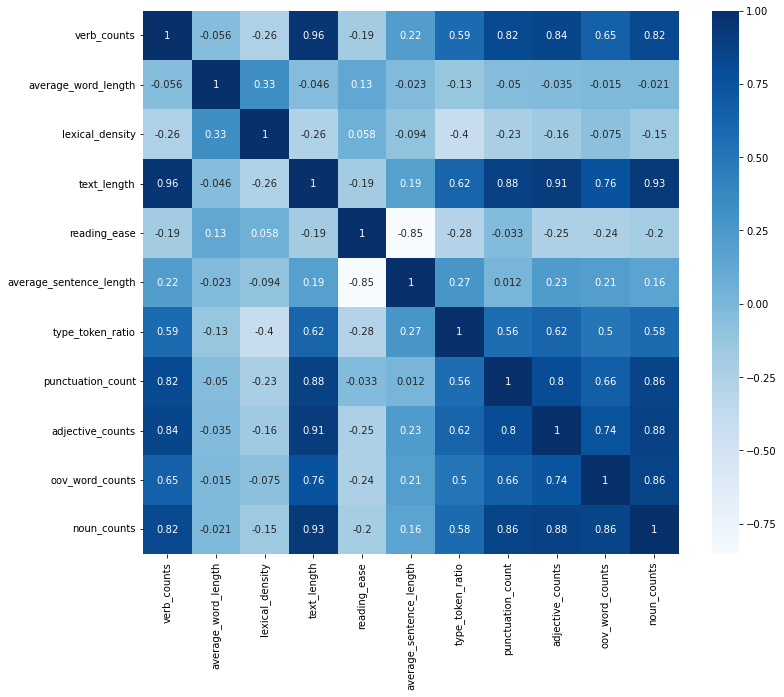

In [45]:
plt.figure(figsize=(12, 10))
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

__Interpretation__

Because the text features are derived from a single text document, the majority of them are correlated to each other, meaning that removing one will affect the importance of the other features in a linear model. So, in order to complete the classification assignment, a viable choice is to employ a tree-based model.

### Classification

__Imports__

In [46]:
from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import (
    OneHotEncoder,
    PolynomialFeatures,
    StandardScaler,
)

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_recall_curve

#### Splitting Data

In [47]:
# Splitting explanatory and target variables
target = "target_region"
X_train, y_train = train_data.drop(columns=[target]), train_data[target]
X_val, y_val = val_data.drop(columns=[target]), val_data[target]
X_test, y_test = test_data.drop(columns=[target]), test_data[target]

In [48]:
results = {}

In [49]:
scoring_metrics = [
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
]

In [50]:
# Adapted from DSCI 573 Lecture Notes:

def cross_validate_model(model, X_train, y_train,
                         X_val, y_val, scoring, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data
    X_val : numpy array or pandas DataFrame
        X in the validation data
    y_val :
        y in the validation data

    Returns
    ----------
        pandas Series with train and validation scores
    """

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    scores = []

    for scoring_function in scoring:
        scores.append(scoring_function(y_train, y_train_pred))
        scores.append(scoring_function(y_val, y_val_pred))

    scores = pd.Series(
        data=scores,
        index=["train_accuracy",
               "test_accuracy",
               "train_precision",
               "test_precision",
               "train_recall",
               "test_recall",
               "train_f1",
               "test_f1"]
    )

    return scores

#### Eliminating Features

In [51]:
def select_features(model,
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    numeric_features,
                    binary_features,
                    n_feats_to_drop=1,
                    verbose=False):
    """
    Eliminates least important features from the dataset

    Parameters
    ----------
    model : scikit-learn model
        ML model to decide the most important features
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data
    X_val : numpy array or pandas DataFrame
        X in the validation data
    y_val :
        y in the validation data
    numeric_features : list
        Original list of Numeric Features
    binary_features : list
        Original list of Binary Features
    n_cols_to_drop : int
        Number of least important columns to drop
    verbose : boolean
            specify whether to print the name of dropped column or not
    Returns
    ----------
        a tuple of newly selected lists of numeric and binary columns
        of most important features
    """

    worst_columns = set()

    X_train_new = X_train.copy()
    X_val_new = X_val.copy()

    for i in range(n_feats_to_drop):

        score = 1
        worst_column = None

        for column in X_train_new.columns:
            X_train_dropped = X_train_new.drop(columns=[column])
            X_val_dropped = X_val_new.drop(columns=[column])

            new_cols = set(X_train_dropped.columns)

            col_transformer = make_column_transformer(
                (StandardScaler(), list(set(numeric_features).intersection(new_cols))),
                (
                    OneHotEncoder(drop="if_binary", dtype="int"),
                    list(set(binary_features).intersection(new_cols))
                )
            )

            pipe = make_pipeline(
                col_transformer, DecisionTreeClassifier()
            )

            results = cross_validate_model(
                pipe,
                X_train_dropped,
                y_train,
                X_val_dropped,
                y_val,
                scoring=scoring_metrics
            )

            if results["test_accuracy"] < score:
                score = results["test_accuracy"]
                worst_column = column

        worst_columns.add(worst_column)
        print(f"Dropped {worst_column}")

        X_train_new = X_train.drop(columns=list(worst_columns))
        X_val_new = X_val.drop(columns=list(worst_columns))

    new_cols = X_train_new.columns

    new_numeric_feats = list(set(numeric_features).intersection(new_cols))
    new_binary_feats = list(set(binary_features).intersection(new_cols))

    assert len(new_cols) == len(X_train.columns) - n_feats_to_drop
    assert len(new_numeric_feats) + len(new_binary_feats) == len(new_cols)

    return new_numeric_feats, new_binary_feats

In [52]:
n_feats_to_keep = 10

model = DecisionTreeClassifier(class_weight="balanced")

numeric_features, binary_features = select_features(
    model, X_train, y_train, X_val, y_val,
    numeric_features_org, binary_features_org,
    n_feats_to_drop=len(X_train.columns) - n_feats_to_keep,
    verbose=True
)

Dropped text_length
Dropped asian_context_feature
Dropped reading_ease
Dropped verb_counts


In [53]:
assert len(numeric_features + binary_features) == n_feats_to_keep

print(f"The number of features in the final training set: {n_feats_to_keep}")

The number of features in the final training set: 10


#### Column Transformations

In [54]:
# Column Transformation

column_transformer = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features)
)

In [55]:
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['average_word_length', 'lexical_density',
                                  'average_sentence_length', 'type_token_ratio',
                                  'punctuation_count', 'adjective_counts',
                                  'oov_word_counts', 'noun_counts']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary', dtype='int'),
                                 ['asian_imp_word', 'non_asian_imp_word'])])

### Model Training

#### Dummy Classifier (Baseline)

In [56]:
results["dummy_classifier"] = cross_validate_model(
    DummyClassifier(),
    X_train,
    y_train,
    X_val,
    y_val,
    scoring=scoring_metrics
)

/Applications/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/miniconda3/envs/573/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
pd.DataFrame(results)

,dummy_classifier
train_accuracy,0.664872
test_accuracy,0.589431
train_precision,0.000000
test_precision,0.000000
train_recall,0.000000
test_recall,0.000000
train_f1,0.000000
test_f1,0.000000


#### Logistic Regression With Polynomial Features

In [58]:
pipe_lr_poly = make_pipeline(
    column_transformer,
    PolynomialFeatures(degree=2),
    LogisticRegression(
        class_weight="balanced",
        max_iter=10000,
        n_jobs=-1,
        random_state=42
    )
)

results["lr_poly"] = cross_validate_model(
    pipe_lr_poly,
    X_train,
    y_train,
    X_val,
    y_val,
    scoring=scoring_metrics
)

In [59]:
pd.DataFrame(results)

,dummy_classifier,lr_poly
train_accuracy,0.664872,0.686406
test_accuracy,0.589431,0.613821
train_precision,0.000000,0.522989
test_precision,0.000000,0.527273
train_recall,0.000000,0.730924
test_recall,0.000000,0.574257
train_f1,0.000000,0.609715
test_f1,0.000000,0.549763


In [60]:
pipe_lr_poly.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['average_word_length',
                                                   'lexical_density',
                                                   'average_sentence_length',
                                                   'type_token_ratio',
                                                   'punctuation_count',
                                                   'adjective_counts',
                                                   'oov_word_counts',
                                                   'noun_counts']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int'),
                         

In [62]:
# Number of output features after applying Polynomial features 

pipe_lr_poly.named_steps['polynomialfeatures'].n_output_features_

66

#### Logistic Regression With Polynomial Features and after Feature Elimination

In [63]:
rfe = RFE(Ridge(), n_features_to_select=30)

pipe_lr_poly_rfe = make_pipeline(
    column_transformer,
    PolynomialFeatures(degree=2),
    rfe,
    LogisticRegression(
        class_weight="balanced",
        max_iter=10000,
        n_jobs=-1,
        random_state=42
    )
)

results["lr_poly_rfe"] = cross_validate_model(
    pipe_lr_poly_rfe,
    X_train,
    y_train,
    X_val,
    y_val,
    return_train_score=True,
    scoring=scoring_metrics
)

In [64]:
pd.DataFrame(results)

,dummy_classifier,lr_poly,lr_poly_rfe
train_accuracy,0.664872,0.686406,0.668910
test_accuracy,0.589431,0.613821,0.646341
train_precision,0.000000,0.522989,0.504399
test_precision,0.000000,0.527273,0.560345
train_recall,0.000000,0.730924,0.690763
test_recall,0.000000,0.574257,0.643564
train_f1,0.000000,0.609715,0.583051
test_f1,0.000000,0.549763,0.599078


#### Decision Tree

In [65]:
pipe_decision_tree = make_pipeline(
    column_transformer, DecisionTreeClassifier(max_depth=3, class_weight="balanced")
)

results["decision_tree_classifier"] = cross_validate_model(
    pipe_decision_tree,
    X_train,
    y_train,
    X_val,
    y_val,
    return_train_score=True,
    scoring=scoring_metrics
)

In [66]:
pd.DataFrame(results)

,dummy_classifier,lr_poly,lr_poly_rfe,decision_tree_classifier
train_accuracy,0.664872,0.686406,0.668910,0.676985
test_accuracy,0.589431,0.613821,0.646341,0.642276
train_precision,0.000000,0.522989,0.504399,0.518219
test_precision,0.000000,0.527273,0.560345,0.573034
train_recall,0.000000,0.730924,0.690763,0.514056
test_recall,0.000000,0.574257,0.643564,0.504950
train_f1,0.000000,0.609715,0.583051,0.516129
test_f1,0.000000,0.549763,0.599078,0.536842


#### Random Forest

In [67]:
pipe_rf = make_pipeline(
    column_transformer, RandomForestClassifier(class_weight="balanced")
)

results["rf_classifier"] = cross_validate_model(
    pipe_rf,
    X_train,
    y_train,
    X_val,
    y_val,
    return_train_score=True,
    scoring=scoring_metrics
)

In [68]:
pd.DataFrame(results)

,dummy_classifier,lr_poly,lr_poly_rfe,decision_tree_classifier,rf_classifier
train_accuracy,0.664872,0.686406,0.668910,0.676985,1.000000
test_accuracy,0.589431,0.613821,0.646341,0.642276,0.650407
train_precision,0.000000,0.522989,0.504399,0.518219,1.000000
test_precision,0.000000,0.527273,0.560345,0.573034,0.659574
train_recall,0.000000,0.730924,0.690763,0.514056,1.000000
test_recall,0.000000,0.574257,0.643564,0.504950,0.306931
train_f1,0.000000,0.609715,0.583051,0.516129,1.000000
test_f1,0.000000,0.549763,0.599078,0.536842,0.418919


#### LGBM Classifier

In [70]:
pipe_lgbm = make_pipeline(
    column_transformer, LGBMClassifier(class_weight="balanced")
)

results["lgbm_classifier"] = cross_validate_model(
    pipe_lgbm,
    X_train,
    y_train,
    X_val,
    y_val,
    return_train_score=True,
    scoring=scoring_metrics
)

In [71]:
pd.DataFrame(results)

,dummy_classifier,lr_poly,lr_poly_rfe,decision_tree_classifier,rf_classifier,lgbm_classifier
train_accuracy,0.664872,0.686406,0.668910,0.676985,1.000000,0.994616
test_accuracy,0.589431,0.613821,0.646341,0.642276,0.650407,0.605691
train_precision,0.000000,0.522989,0.504399,0.518219,1.000000,0.988048
test_precision,0.000000,0.527273,0.560345,0.573034,0.659574,0.524390
train_recall,0.000000,0.730924,0.690763,0.514056,1.000000,0.995984
test_recall,0.000000,0.574257,0.643564,0.504950,0.306931,0.425743
train_f1,0.000000,0.609715,0.583051,0.516129,1.000000,0.992000
test_f1,0.000000,0.549763,0.599078,0.536842,0.418919,0.469945


#### XGBoost Classifier

In [72]:
pipe_xgb = make_pipeline(
    column_transformer, XGBClassifier()
)

results["xgb_classifier"] = cross_validate_model(
    pipe_xgb,
    X_train,
    y_train,
    X_val,
    y_val,
    return_train_score=True,
    scoring=scoring_metrics
)

[12:30:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/miniconda3/envs/573/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [73]:
pd.DataFrame(results)

,dummy_classifier,lr_poly,lr_poly_rfe,decision_tree_classifier,rf_classifier,lgbm_classifier,xgb_classifier
train_accuracy,0.664872,0.686406,0.668910,0.676985,1.000000,0.994616,0.998654
test_accuracy,0.589431,0.613821,0.646341,0.642276,0.650407,0.605691,0.581301
train_precision,0.000000,0.522989,0.504399,0.518219,1.000000,0.988048,1.000000
test_precision,0.000000,0.527273,0.560345,0.573034,0.659574,0.524390,0.485714
train_recall,0.000000,0.730924,0.690763,0.514056,1.000000,0.995984,0.995984
test_recall,0.000000,0.574257,0.643564,0.504950,0.306931,0.425743,0.336634
train_f1,0.000000,0.609715,0.583051,0.516129,1.000000,0.992000,0.997988
test_f1,0.000000,0.549763,0.599078,0.536842,0.418919,0.469945,0.397661


#### CatBoost Classifier

In [74]:
pipe_cat_boost = make_pipeline(
    column_transformer, CatBoostClassifier(
        auto_class_weights="Balanced",
        verbose=False
    )
)

results["cat_boost_classifier"] = cross_validate_model(
    pipe_cat_boost,
    X_train,
    y_train,
    X_val,
    y_val,
    return_train_score=True,
    scoring=scoring_metrics
)

In [75]:
pd.DataFrame(results)

,dummy_classifier,lr_poly,lr_poly_rfe,decision_tree_classifier,rf_classifier,lgbm_classifier,xgb_classifier,cat_boost_classifier
train_accuracy,0.664872,0.686406,0.668910,0.676985,1.000000,0.994616,0.998654,0.921938
test_accuracy,0.589431,0.613821,0.646341,0.642276,0.650407,0.605691,0.581301,0.613821
train_precision,0.000000,0.522989,0.504399,0.518219,1.000000,0.988048,1.000000,0.830450
test_precision,0.000000,0.527273,0.560345,0.573034,0.659574,0.524390,0.485714,0.532609
train_recall,0.000000,0.730924,0.690763,0.514056,1.000000,0.995984,0.995984,0.963855
test_recall,0.000000,0.574257,0.643564,0.504950,0.306931,0.425743,0.336634,0.485149
train_f1,0.000000,0.609715,0.583051,0.516129,1.000000,0.992000,0.997988,0.892193
test_f1,0.000000,0.549763,0.599078,0.536842,0.418919,0.469945,0.397661,0.507772


### Feature Importances

__Imports__

In [86]:
import shap

In [76]:
column_transformer_shap = make_column_transformer(
    (StandardScaler(), numeric_features_org),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features_org)
)

In [77]:
column_transformer_shap.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['verb_counts', 'average_word_length',
                                  'lexical_density', 'text_length',
                                  'reading_ease', 'average_sentence_length',
                                  'type_token_ratio', 'punctuation_count',
                                  'adjective_counts', 'oov_word_counts',
                                  'noun_counts']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary', dtype='int'),
                                 ['asian_context_feature', 'asian_imp_word',
                                  'non_asian_imp_word'])])

In [78]:
pipe_xgb = make_pipeline(
    column_transformer_shap, XGBClassifier()
)

In [79]:
standard_scaler_names = pipe_xgb.named_steps['columntransformer'].named_transformers_['standardscaler'].get_feature_names_out().tolist() 
ohe_names = pipe_xgb.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist()

all_feature_names = standard_scaler_names + ohe_names

In [80]:
all_feature_names

['verb_counts',
 'average_word_length',
 'lexical_density',
 'text_length',
 'reading_ease',
 'average_sentence_length',
 'type_token_ratio',
 'punctuation_count',
 'adjective_counts',
 'oov_word_counts',
 'noun_counts',
 'asian_context_feature_1',
 'asian_imp_word_1',
 'non_asian_imp_word_1']

#### Feature Importances For Individual Training Examples

In [81]:
X_train_enc = pd.DataFrame(
    data=column_transformer_shap.transform(X_train),
    columns=all_feature_names,
    index=X_train.index,
)
X_train_enc.head()

,verb_counts,average_word_length,lexical_density,text_length,reading_ease,average_sentence_length,type_token_ratio,punctuation_count,adjective_counts,oov_word_counts,noun_counts,asian_context_feature_1,asian_imp_word_1,non_asian_imp_word_1
0,0.861222,-0.064621,-1.448222,1.468928,-0.812504,1.223431,0.492405,0.355641,0.207487,1.612237,1.718711,0.0,0.0,1.0
1,-0.625262,0.005661,0.439686,-0.676892,-0.170301,-0.043975,-1.251686,-0.779014,-0.432194,-0.585529,-0.697937,0.0,0.0,0.0
2,1.342143,0.049847,-0.233805,1.690322,-0.364993,0.244072,1.207929,0.489129,0.527328,1.172684,2.241230,0.0,1.0,0.0
3,-0.275501,-0.122532,-0.027383,-0.353316,0.105584,-0.248809,0.000482,0.021919,-0.325580,-0.145975,-0.273390,0.0,1.0,0.0
4,-0.625262,-0.340468,-1.020685,-0.710953,0.622071,-0.166875,-1.430567,-0.712270,-0.858648,-0.695417,-0.730594,0.0,0.0,1.0


#### Feature Importances For Individual Test Examples

In [82]:
X_test_enc = pd.DataFrame(
    data=column_transformer_shap.transform(X_test),
    columns=all_feature_names,
    index=X_test.index,
)
X_test_enc.head()

,verb_counts,average_word_length,lexical_density,text_length,reading_ease,average_sentence_length,type_token_ratio,punctuation_count,adjective_counts,oov_word_counts,noun_counts,asian_context_feature_1,asian_imp_word_1,non_asian_imp_word_1
0,-0.537822,-0.177356,0.257378,-0.523619,0.616653,-0.573981,-0.536162,-0.512036,-0.432194,-0.695417,-0.404020,0.0,0.0,0.0
1,-0.275501,0.053041,0.613200,-0.302225,-1.453681,1.307925,0.134642,-0.311803,-0.005740,-0.255864,-0.142761,1.0,0.0,0.0
2,-0.406662,-0.276219,0.217593,-0.481044,0.324074,-0.402434,-0.759763,-0.111570,-0.005740,-0.585529,-0.599964,0.0,0.0,0.0
3,-0.056901,-0.035644,0.383805,-0.242619,-1.032929,1.523000,0.089922,-0.779014,-0.645421,0.073801,-0.175418,0.0,0.0,0.0
4,0.424020,-0.093694,-0.456809,0.668503,0.204027,0.022596,1.029048,0.822851,0.420714,0.073801,0.510387,0.0,0.0,1.0


In [83]:
pipe_xgb.fit(X_train, y_train)

[12:31:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Applications/miniconda3/envs/573/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['verb_counts',
                                                   'average_word_length',
                                                   'lexical_density',
                                                   'text_length',
                                                   'reading_ease',
                                                   'average_sentence_length',
                                                   'type_token_ratio',
                                                   'punctuation_count',
                                                   'adjective_counts',
                                                   'oov_word_counts',
                                                   'noun_counts']),
                                                 ('on

In [87]:
xgb_explainer = shap.TreeExplainer(pipe_xgb.named_steps["xgbclassifier"])
train_xgb_shap_values = xgb_explainer.shap_values(X_train_enc)

In [88]:
# We are only extracting shapely values for the first 100 test examples for speed.
test_lgbm_shap_values = xgb_explainer.shap_values(X_test_enc[:100])

In [89]:
shap.initjs()

#### Average Feature Importance For Training Examples

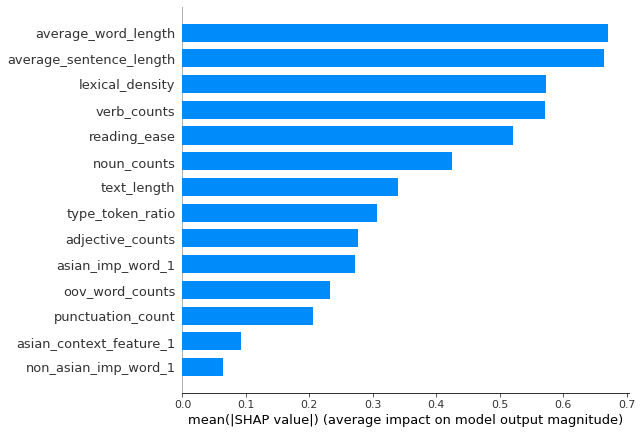

<Figure size 432x288 with 0 Axes>

In [90]:
shap.summary_plot(train_xgb_shap_values, X_train_enc, plot_type="bar")
plt.savefig('bar.png')

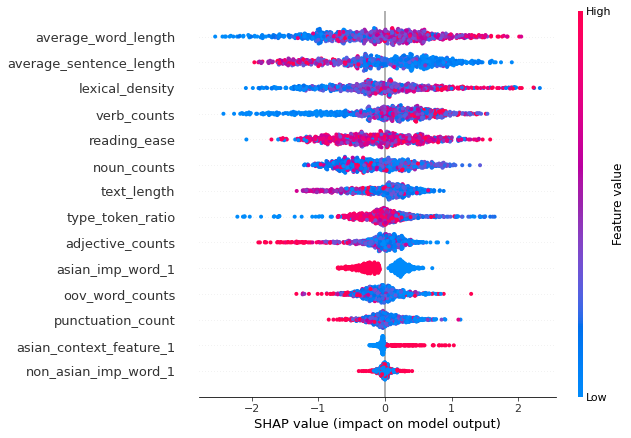

<Figure size 432x288 with 0 Axes>

In [91]:
shap.summary_plot(train_xgb_shap_values, X_train_enc)
plt.savefig('summary.png')

### Model Evaluation

In [92]:
# XGBoost is performing the best

pipe_xgb.fit(X_train, y_train)

score = pipe_xgb.score(X_test, y_test)

[12:32:24] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1614825350330/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [93]:
print(f"Accuracy on the test set using XGB: {np.round(score, 3)}")

Accuracy on the test set using XGB: 0.694


## Feature selection and performance

In order to determine which 10 features to choose, we perform feature ablation. This involves creating a DecisionTree Classifier and iterating through all the features and drop one at a time to see the impact on the model's performance on the development data set. The features that we decided to drop were `lexical_density`, `type_token_ratio`, `non_asian_imp_word` and `avreage_word_length`. These 4 had the highest scores on the development data when they were removed from the dataset. The remaining and final features were:
- `reading_ease`
- `verb_counts`
- `noun_counts`
- `punctuation_count`
- `adjective_counts`
- `oov_word_counts`
- `average_sentence_length`
- `text_length`
- `asian_context_feature`
- `asian_imp_word`

After we had selected our features, we decided to try various different models in order to find something that would best fit our features. Overall, we tried 8 models and achieved the following results for the development set. Since we knew we had a class imbalance, we also added `class_weight="balanced"` to our model in order to address this and this ameliorated the scores for all the models.

 <table>
  <tr>
      <th></th>
    <th>development accuracy</th>
    <th>development precision</th>
    <th>development recall</th>
    <th>development f1</th>
  </tr>
  <tr>
      <td>Dummy Classifier</td>
      <td>0.589431</td>
      <td>0.0</td>
      <td>0.0</td>
       <td>0.0</td>
  </tr>
  <tr>
      <td>Polynomial Logistic Regression</td>
      <td>0.626016</td>
      <td>0.536585</td>
      <td>0.653465</td>
       <td>0.589286</td>
  </tr>
      <tr>
      <td>Polynomial Logistic Regression RFE</td>
      <td>0.634146</td>
      <td>0.541353</td>
      <td>0.712871</td>
       <td>0.615385</td>
  </tr>
  <tr>
      <td>Decision Tree Classifier</td>
      <td>0.552846</td>
      <td>0.452632</td>
      <td>0.425743</td>
       <td>0.438776</td>
  </tr>
  <tr>
      <td>Random Forest Classifier</td>
      <td>0.630081</td>
      <td>0.592593</td>
      <td>0.316832</td>
       <td>0.412903</td>
  </tr>
   <tr>
      <td>LGBM Classifier</td>
      <td>0.642276</td>
      <td>0.576471</td>
      <td>0.485149</td>
       <td>0.526882</td>
    </tr>
   <tr>
      <td>XGB Classifier</td>
      <td>0.695122</td>
      <td>0.680556</td>
      <td>0.485149</td>
       <td>0.566474</td>
  </tr>
   <tr>
      <td>CatBoost Classifier</td>
      <td>0.617886</td>
      <td>0.535354</td>
      <td>0.524752</td>
       <td>0.530000</td>
  </tr>
</table> 




As we can see above, XGB Classifier perform the best with our development data. 

It would be interesting to investigate within this XGB classifier which features were the most important. 

## Feature Importance using SHAP (Shapely Additive Explanations) 

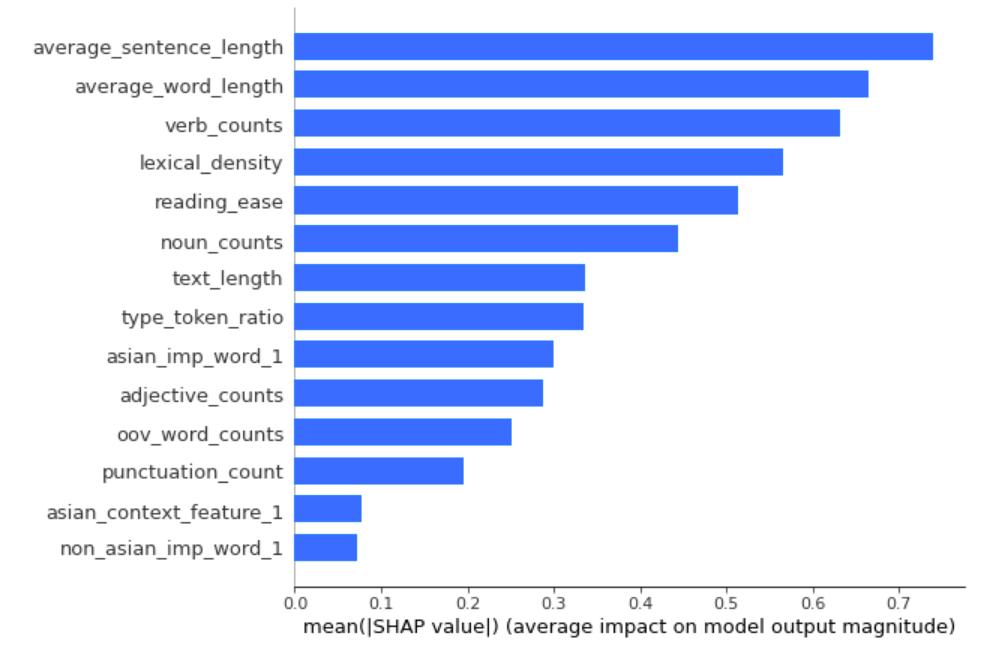

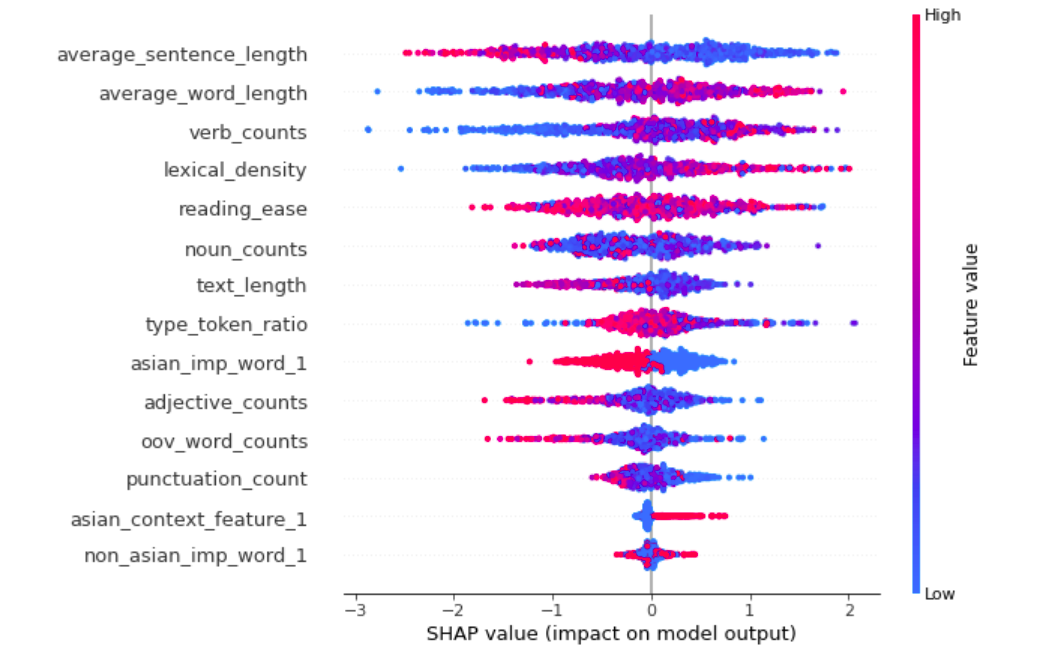

**Summary of Feature Importance**

We have used SHAP values to understand the contribution of each feature to the prediction. We have generated two summary plots as shown above to understand the contribution of the features.

**Plot 1** 

The first plot shows shows the average SHAP value for each feature. Based on the 1st plot generated, we can say that the feature `average_sentence_length` has highest average impact on the model's output (seems to be most important feature) and the feature `non_asian_imp_word` has the lowest average impact on the model's output.

**Plot 2**

The second plot above shows the most important features for predicting the output and it also shows the direction of how the features are going to drive the prediction. As we can see above, this plot shows the relationship between the value of a feature and the impact on the prediction. Based on the plot above, we can see that few of the features mentioned seem to be important and have significant impact on the predictions :

In the case of `average_sentence_length`, we can see that high feature value would lead to a low SHAP value which means that bigger values for this feature are going to push the predictions to class 0. 

In the case of `average_word_length`, we can see that high value of this feature value leads to big SHAP values which means that high values of this feature are going to push the predictions to class 1 and as the value of this feature reduces, would  give lower SHAP values and push the predictions towards class 0.

We can see according to the above plots that the top 5 most important features include `average_sentence_length`, `average_word_length`, `lexical_density`, `verb_counts` and `reading_ease`.

We can also observe that the set of important features shown by SHAP are quite different from those selected by the `DecisionTreeClassifier`. Exploring further, we noticed that the scores during feature elimination using Decision Tree were very close and even the features eliminated changed with each execution. There is some scope for improvement here, which we will leave for the next time.

After choosing this model, we decided to perform the final test on our test data. These are the results we achieved 

## Conclusions and distribution of work

### Conclusions

After the series of analysis, we can conclude that the XGB Classifier is our best model with the following features:
- `reading_ease`
- `verb_counts`
- `noun_counts`
- `punctuation_count`
- `adjective_counts`
- `oov_word_counts`
- `average_sentence_length`
- `text_length`
- `asian_context_feature`
- `asian_imp_word`